In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models,backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy


In [4]:
import os
from PIL import Image

def load_images_and_labels(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = Image.open(img_path).convert('L') 
                img_array = np.array(img) 
                images.append(img_array)
                labels.append(int(label)) 
    return np.array(images), np.array(labels)



x_train, y_train = load_images_and_labels('Hindi-MNIST/train')
x_valid, y_valid = load_images_and_labels('Hindi-MNIST/test')

x_train = x_train.reshape(-1, 32,32, 1)
x_valid = x_valid.reshape(-1, 32,32, 1)

x_train = x_train / 255.0
x_valid = x_valid / 255.0


In [8]:
def shuffle_data(x, y):
    permutation = np.random.permutation(len(x))
    return x[permutation], y[permutation]


x_train, y_train = shuffle_data(x_train, y_train)
x_valid, y_valid = shuffle_data(x_valid, y_valid)

In [9]:
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(32, 32, 1))
conv1 = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
conv2 = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(conv1)
x = layers.Flatten()(conv2)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Latent space sampling
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     65,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 3)         │         51 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 3)         │         51 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 3)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,470 (329.96 KB)

 Trainable params: 84,470 (329.96 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
outputs = layers.Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,065 (281.50 KB)

 Trainable params: 72,065 (281.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Compute reconstruction loss without flattening
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    binary_crossentropy(data, reconstruction), axis=(1, 2) 
                )
            )
            reconstruction_loss *= 32*32
            
            # Compute KL divergence loss
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=-1))
            kl_loss *= -0.5
        
            total_loss = reconstruction_loss + kl_loss
        
        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

vae = VAEModel(encoder, decoder)
vae.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)
vae.summary()

vae.fit(
 x_train,
 epochs=64,
 batch_size=128,
 validation_data=(x_valid, x_valid)
)

Model: "vae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 3), (None, 3), │        84,470 │
│                                 │ (None, 3)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 1)      │        72,065 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,535 (611.46 KB)

 Trainable params: 156,535 (611.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/64
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - kl_loss: 98.4993 - loss: 520681.6875 - reconstruction_loss: 520583.1875 - val_loss: 0.0000e+00
Epoch 2/64
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - kl_loss: 178.7518 - loss: 436431.9375 - reconstruction_loss: 436253.1875 - val_loss: 0.0000e+00
Epoch 3/64
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - kl_loss: 176.4768 - loss: 400114.7812 - reconstruction_loss: 399938.3125 - val_loss: 0.0000e+00
Epoch 4/64
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - kl_loss: 164.5580 - loss: 387196.7812 - reconstruction_loss: 387032.2188 - val_loss: 0.0000e+00
Epoch 5/64
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - kl_loss: 151.5924 - loss: 378376.6875 - reconstruction_loss: 378225.0938 - val_loss: 0.0000e+00
Epoch 6/64
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - kl_loss: 138.9838 - loss: 372505.5312 - reconstruction_loss: 372366.5312 - val_loss: 0.0000e+00
Epoch 7/64
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - kl_loss: 129.0839 - loss: 367795.2812 - 

In [17]:
from keras.src.saving import load_model

vae=load_model('vae.h5', custom_objects={'VAEModel': VAEModel} ,safe_mode=False)
vae.summary()

TypeError: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class '__main__.VAEModel'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of VAEModel from its config.

Received config={'name': 'vae_model', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: VAEModel.__init__() missing 2 required positional arguments: 'encoder' and 'decoder'

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


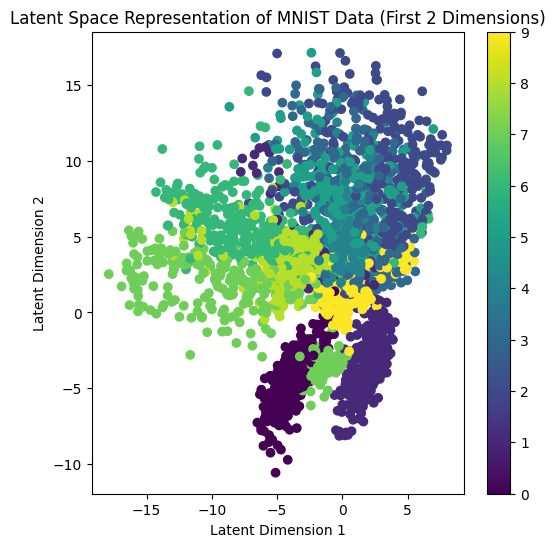

In [30]:
# Predict using the encoder to get the latent space representation
x_test_encoded = encoder.predict(x_valid, batch_size=128)[2]  

x_test_encoded_2d = x_test_encoded[:, :] 

# Plotting the 2D scatter plot of the latent space
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded_2d[:, 1], x_test_encoded_2d[:, 2], c=y_valid, cmap='viridis')  # Use y_valid directly for coloring
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Representation of MNIST Data (First 2 Dimensions)')
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


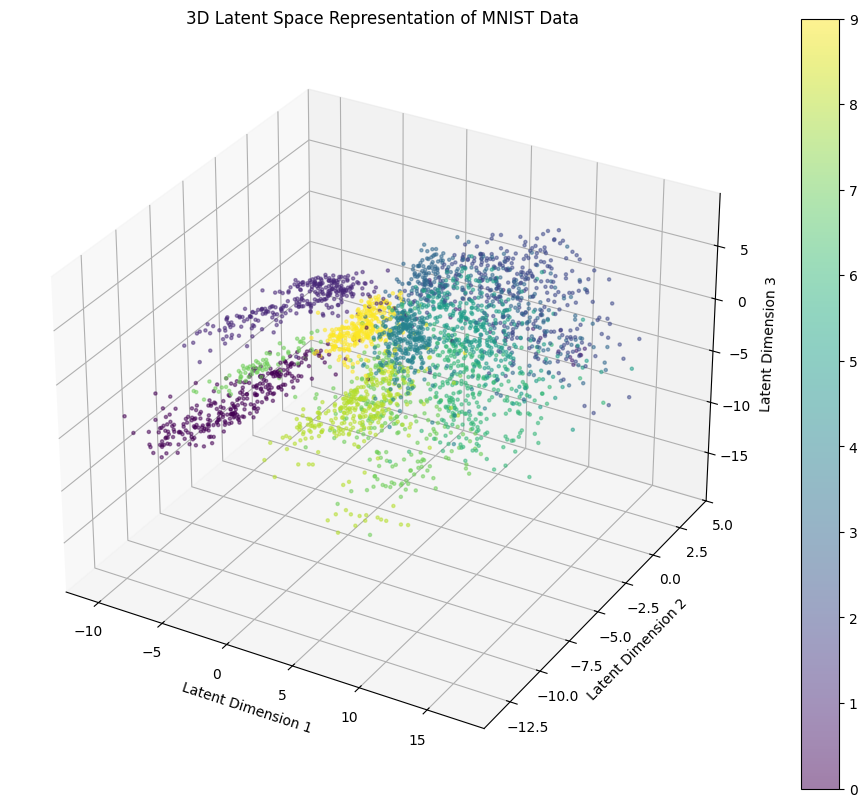

In [27]:
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import matplotlib.pyplot as plt
import numpy as np

# Encode the entire test dataset
x_test_encoded_3d = encoder.predict(x_valid, batch_size=128)[2]

x_test_encoded_3d = np.array(x_test_encoded_3d)

if y_valid.ndim > 1:
    y_valid_labels = np.argmax(y_valid, axis=1)
else:
    y_valid_labels = y_valid

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    
    x_test_encoded_3d[:, 2],
    x_test_encoded_3d[:, 0],
    
    x_test_encoded_3d[:, 1], 
     
    c=y_valid,
    cmap='viridis',
    alpha=0.5, 
    s=5  
)


plt.colorbar(scatter)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')
plt.title('3D Latent Space Representation of MNIST Data')

plt.savefig('Images/3d_latent_space_HindiMNIST.png', dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━

OSError: cannot write mode F as PNG

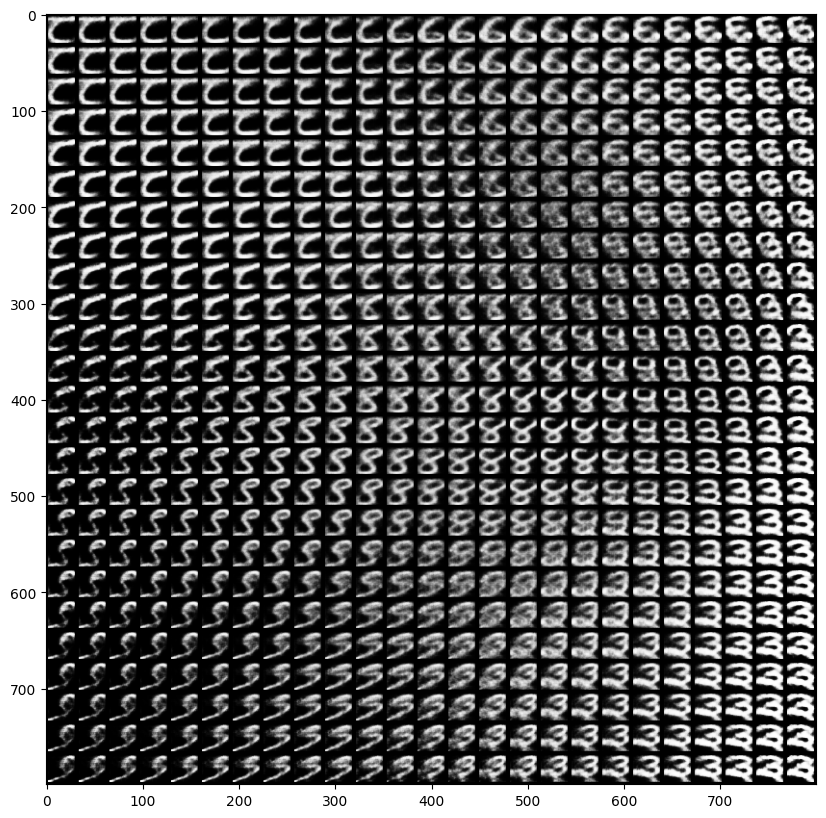

In [24]:
n = 25  # Number of images per dimension
digit_size = 32  # MNIST digit size (28x28 pixels)
figure = np.zeros((digit_size * n, digit_size * n))  # Initialize a large empty canvas

# Linearly spaced coordinates for creating the grid
grid_x = np.linspace(-10, 1, n)
grid_y = np.linspace(-5, 5, n)

# Iterate over the grid to fill in digits generated from the latent space
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Create a 3D latent space sample with the first two dimensions varying, and the third dimension fixed
        z_sample = np.array([[xi, yi,2.5]])  # Here, we set the third dimension to 0.0
        x_decoded = decoder.predict(z_sample)  # Decode the latent space sample into an image
        digit = x_decoded[0].reshape(digit_size, digit_size)  # Reshape the output to 28x28
        
        # Place the generated digit in the right location of the large canvas
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot the manifold of generated digits
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')

plt.title('Generated Digits from the 3D Latent Space')
plt.axis('off')
plt.show()


In [25]:
data = Image.fromarray(np.uint8(figure * 255))  # Scale floating point values to 0-255 range
data = data.convert('L')

data.save('figure.png')

In [26]:
vae.save('vaeHindi.h5')
vae.save('vaeHindi.keras')
vae.save_weights('mnistHindi.weights.h5')

C:\Users\Akshay Gupta\PycharmProjects\PaperVAE\.venv\lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae.compile(optimizer='adam', loss=lambda y_true, y_pred: 0.0)

  return {key: serialize_keras_object(value) for key, value in obj.items()}
